# Find IT UGM - ODE 

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool, cv
import optuna

import xgboost as xgb

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from category_encoders import OrdinalEncoder as oe

# custom plot seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

np.random.seed(5)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Import Custom Classes / Function

In [3]:
from model import RandomForest

## Data Preparation + Cleansing

### Features

`h1n1_concern` - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.

`h1n1_knowledge` - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

`behavioral_antiviral_meds` - Has taken antiviral medications. (binary)

`behavioral_avoidance` - Has avoided close contact with others with flu-like symptoms. (binary)

`behavioral_face_mask` - Has bought a face mask. (binary)

`behavioral_wash_hands` - Has frequently washed hands or used hand sanitizer. (binary)

`behavioral_large_gatherings` - Has reduced time at large gatherings. (binary)

`behavioral_outside_home` - Has reduced contact with people outside of own household. (binary)

`behavioral_touch_face` - Has avoided touching eyes, nose, or mouth. (binary)

`doctor_recc_h1n1` - H1N1 flu vaccine was recommended by doctor. (binary)

`doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)

`chronic_med_condition` - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

`child_under_6_months` - Has regular close contact with a child under the age of six months. (binary)

`health_worker` - Is a healthcare worker. (binary)

`health_insurance` - Has health insurance. (binary)

`opinion_h1n1_vacc_effective` - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_h1n1_risk` - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_h1n1_sick_from_vacc` - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_seas_sick_from_vacc` - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`age_group` - Age group of respondent.

`education` - Self-reported education level.

`race` - Race of respondent.

`sex` - Sex of respondent.

`income_poverty` - Household annual income of respondent with respect to 2008 Census poverty thresholds.

`marital_status` - Marital status of respondent.

`rent_or_own` - Housing situation of respondent.

`employment_status` - Employment status of respondent.

`hhs_geo_region` - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

`census_msa` - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

`household_adults` - Number of other adults in household, top-coded to 3.

`household_children` - Number of children in household, top-coded to 3.

`employment_industry` - Type of industry respondent is employed in. Values are represented as short random character strings.

`employment_occupation` - Type of occupation of respondent. Values are represented as short random character strings.

### Target variables :
`h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.

`seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes.

### Loading Data

In [4]:
df_features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")
df_labels = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

df_test_features = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [5]:
df_labels.columns

Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

In [6]:
df_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [7]:
df_test_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


### Handling null data (prev method)

In [202]:
df_features.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

Features with null data: 

`h1n1_concern`                      92 - (0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.)

`h1n1_knowledge`                   116 - (0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.)

`behavioral_antiviral_meds`         71 - (binary)

`behavioral_avoidance`             208 - (binary)

`behavioral_face_mask`              19 - (binary)

`behavioral_wash_hands`             42 - (binary)

`behavioral_large_gatherings`       87 - (binary)

`behavioral_outside_home`           82 - (binary)

`behavioral_touch_face`            128 - (binary)

`doctor_recc_h1n1`                2160 - (binary)

`doctor_recc_seasonal`            2160 - (binary)

`chronic_med_condition`            971 - (binary)

`child_under_6_months`             820 - (binary)

`health_worker`                    804 - (binary)

`health_insurance`               12274 - (binary)

`opinion_h1n1_vacc_effective`      391 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_h1n1_risk`                388 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_h1n1_sick_from_vacc`      395 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`opinion_seas_vacc_effective`      462 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_seas_risk`                514 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_seas_sick_from_vacc`      537 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`education`                       1407 - ('< 12 Years', '12 Years', 'College Graduate', 'Some College')

`income_poverty`                  4423 - ('Below Poverty', '<= $75,000, Above Poverty', '> $75,000')

`marital_status`                  1408 - ('Not Married', 'Married')

`rent_or_own`                     2042 - ('own', 'rent')

`employment_status`               1463 - ('Not in Labor Force', 'Employed', 'Unemployed')

`household_adults`                 249 - (0, 1, 2, 3)

`household_children`               249 - (0, 1, 2, 3)

`employment_industry`            13330 - ('pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh','ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf','arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax','dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo', 'qnlwzans')

`employment_occupation`          13470 - ('xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp', 'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi', 'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss', 'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew', 'uqqtjvyb', 'pvmttkik', 'dcjcmpih')

In [203]:
df_test_features.isna().sum()

h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
marital_status                  1442
r

In [204]:
df_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

`df_labels` doesn't contain any null data, so null data cleaning will be done to `df_features` only

In [205]:
df_features["employment_occupation"].unique()

array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [206]:
df_features = pd.read_csv("data/training_set_features.csv")
df_test_features = pd.read_csv("data/test_set_features.csv")

#### Education columns

With the assumption that education is affected by sex and age group, education will be filled using RF on sex and age group columns

##### Train Data

In [207]:
age_group = pd.get_dummies(df_features["age_group"], prefix="age")
sex = pd.get_dummies(df_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_features = df_features.fillna(education_predict[["education"]])

##### Test Data

In [208]:
age_group = pd.get_dummies(df_test_features["age_group"], prefix="age")
sex = pd.get_dummies(df_test_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_test_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_test_features = df_test_features.fillna(education_predict[["education"]])

#### Employment Occupation and Industry Columns

In [209]:
df_features[["employment_occupation", "employment_industry", "employment_status"]].loc[(df_features["employment_status"] == "Unemployed") | (df_features["employment_status"] == "Not in Labor Force")].count()

employment_occupation        0
employment_industry          0
employment_status        11684
dtype: int64

NaN happened because the respondent is "Unemployed" or "Not in Labor" because of that, we can fill the NaN value with some specific value, such as "xxxxx"

In [210]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

#### Employment Status Columns

In [211]:
df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

employment_occupation    1463
employment_industry      1463
employment_status           0
dtype: int64

Because of above details, employment_status with NaN data will be filled with "Unemployed'

In [212]:
df_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")

#### Other Columns

other features will be filled with the largest data / mode

In [213]:
df_features.fillna(df_features.mode().iloc[0], inplace=True)
df_test_features.fillna(df_test_features.mode().iloc[0], inplace=True)

<AxesSubplot:>

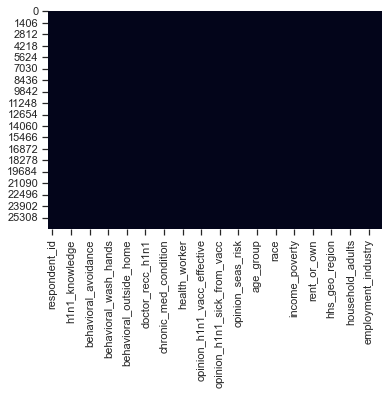

In [214]:
sns.heatmap(df_features.isnull(), cbar=False)

<AxesSubplot:>

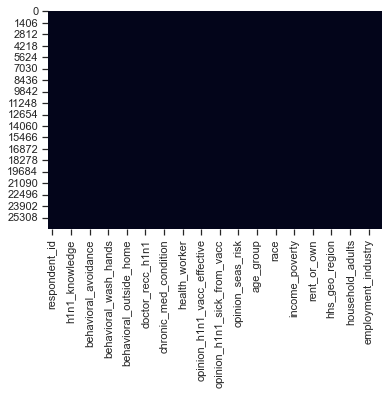

In [215]:
sns.heatmap(df_test_features.isnull(), cbar=False)

### Handling null data (updated method)

In [8]:
numerical_cols = df_features.select_dtypes('number').columns

categorical_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ordinal_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [9]:
for col in (categorical_cols + ordinal_cols):
    df_features[col] = df_features[col].fillna(value='None')

for col in numerical_cols:
    df_features[col] = df_features[col].fillna(value=-1)

In [10]:
for col in (categorical_cols + ordinal_cols):
    df_test_features[col] = df_test_features[col].fillna(value='None')

for col in numerical_cols:
    df_test_features[col] = df_test_features[col].fillna(value=-1)

## EDA

In [22]:
# delete soon
df_features.select_dtypes(include=['int64', 'float64']).columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [23]:
# delete soon

df_features.select_dtypes(include=['object']).columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

Numeric

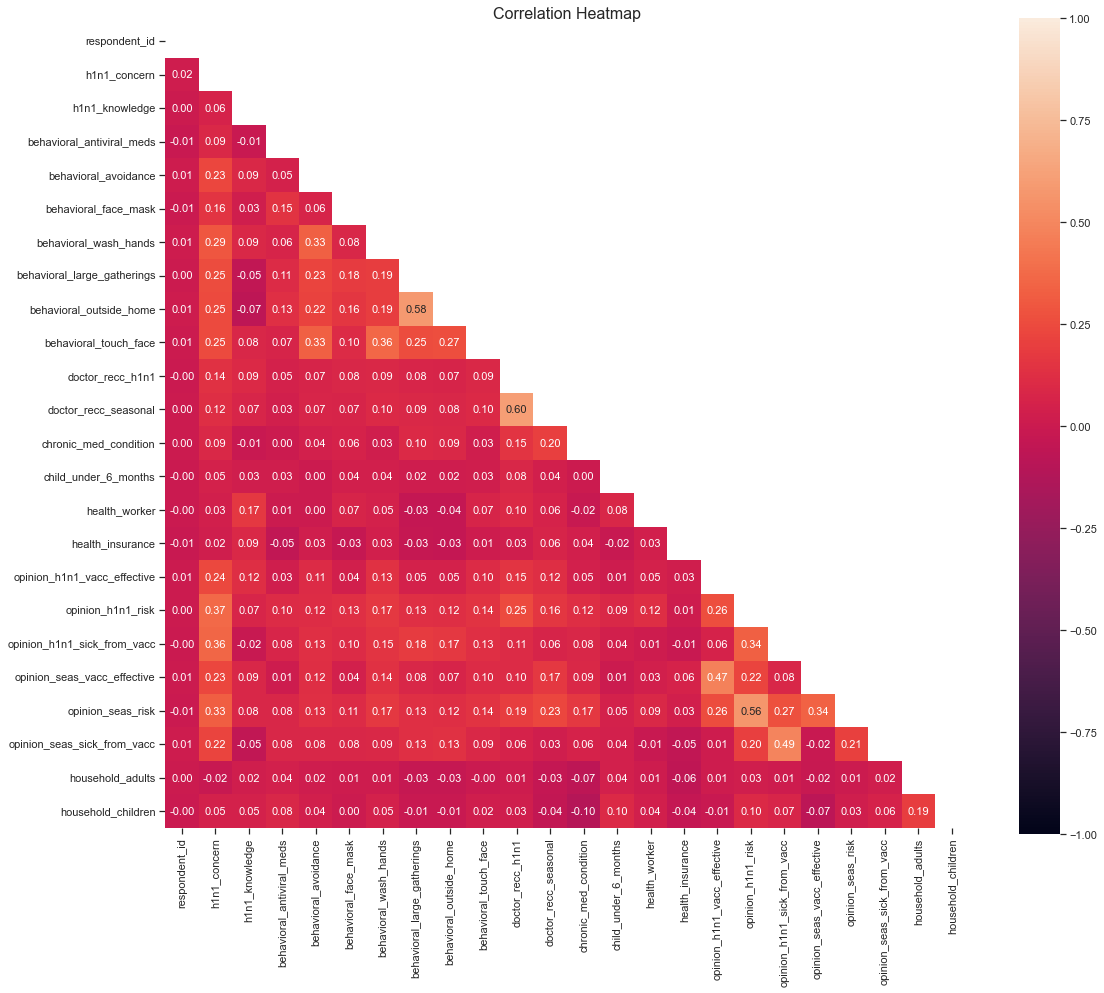

In [24]:
# correlation matrix

plt.figure(figsize=(18,15))

mask = np.triu(np.ones_like(df_features.corr(numeric_only=True), dtype=bool))
sns.heatmap(df_features.corr(), vmin=-1, vmax=1, annot=True, square=True, mask=mask, 
            fmt='.2f', annot_kws={'size':11})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Text(0, 0.5, 'Count')

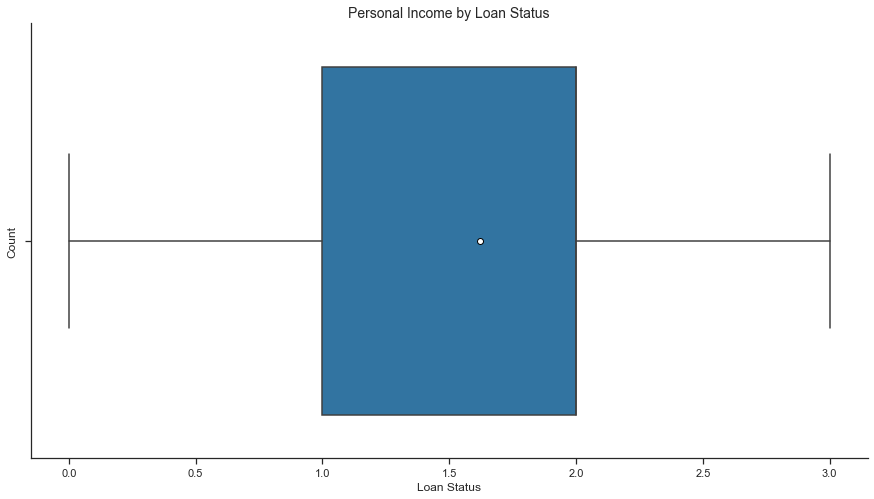

In [25]:
plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=df_features, x='h1n1_concern', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax1.set_title('Personal Income by Loan Status', fontsize=14)
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

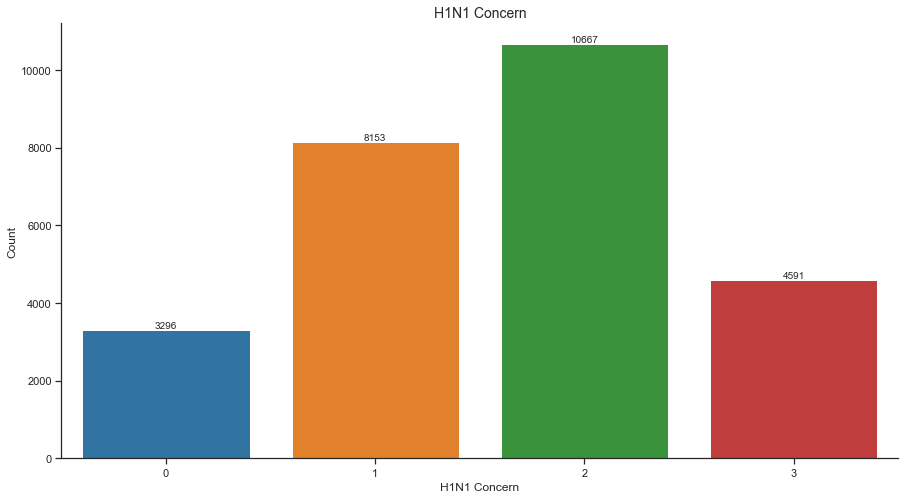

In [26]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='h1n1_concern')
ax.set_title("H1N1 Concern", fontsize=14)
ax.set_xlabel('H1N1 Concern')
ax.set_xticklabels([0,1,2,3])
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

Categorical

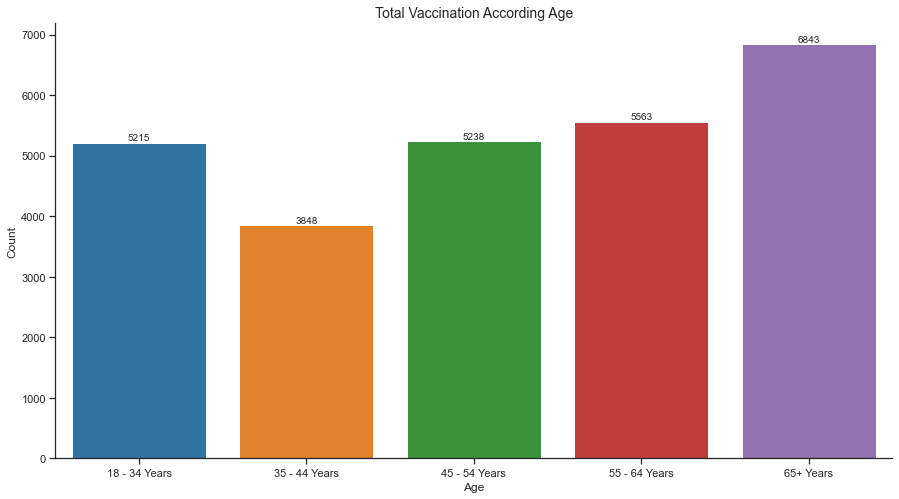

In [27]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='age_group', 
                   order=['18 - 34 Years','35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
ax.set_title("Total Vaccination According Age", fontsize=14)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

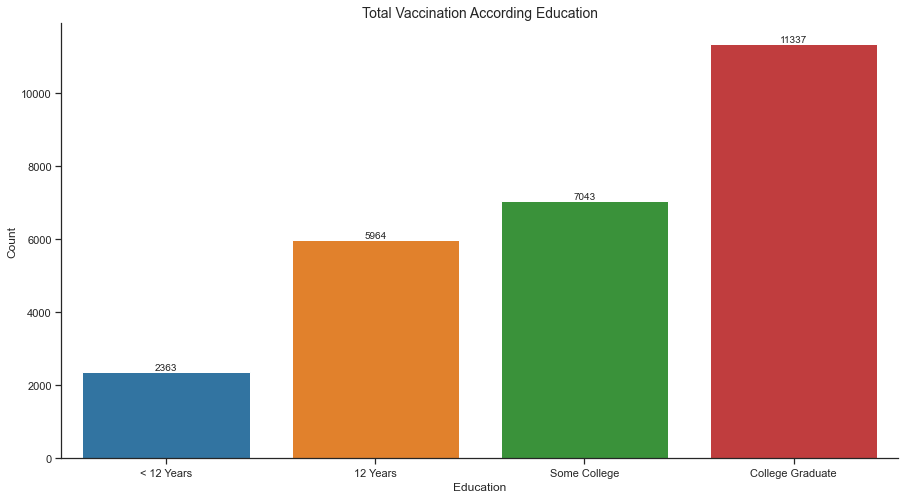

In [28]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='education',
                   order=['< 12 Years', '12 Years', 'Some College', 'College Graduate'])
ax.set_title("Total Vaccination According Education", fontsize=14)
ax.set_xlabel('Education')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

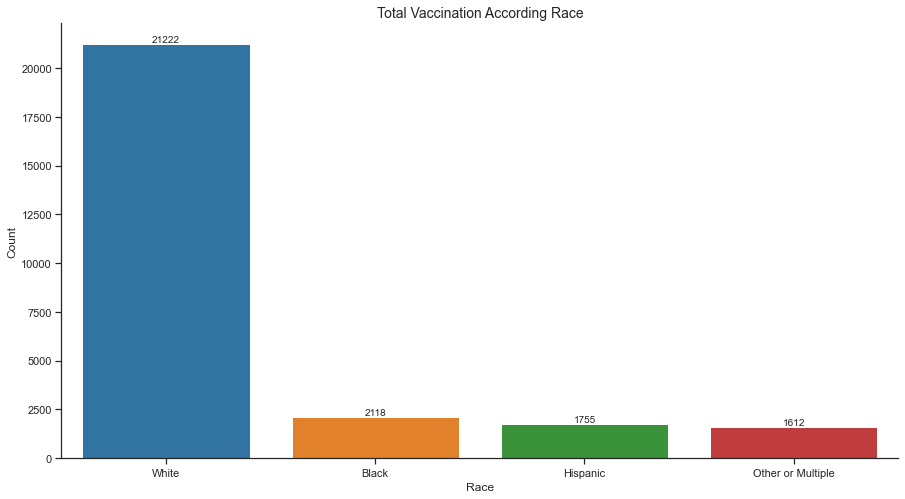

In [29]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='race', order=df_features['race'].value_counts().index)
ax.set_title("Total Vaccination According Race", fontsize=14)
ax.set_xlabel('Race')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

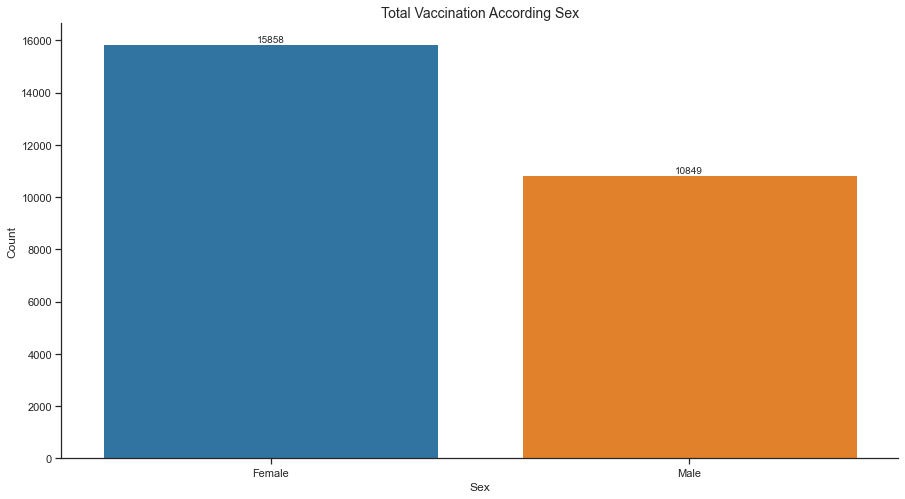

In [30]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='sex', order=df_features['sex'].value_counts().index)
ax.set_title("Total Vaccination According Sex", fontsize=14)
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

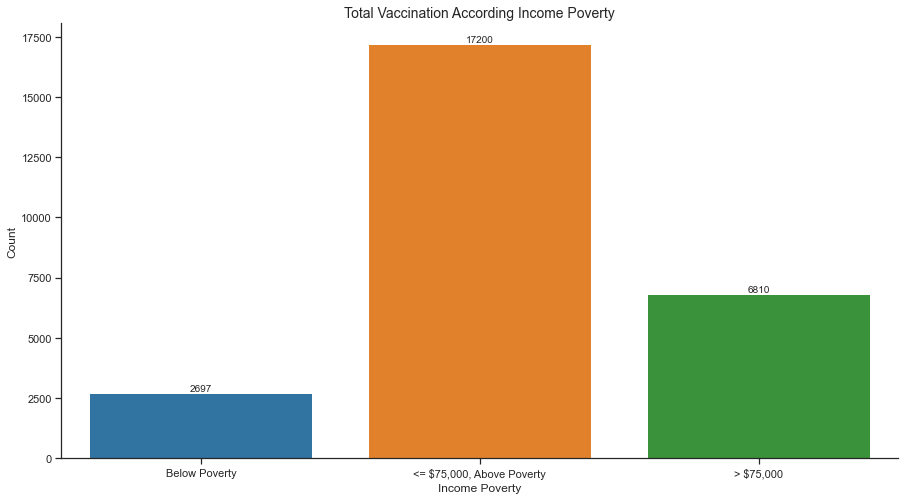

In [31]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='income_poverty', order=['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])
ax.set_title("Total Vaccination According Income Poverty", fontsize=14)
ax.set_xlabel('Income Poverty')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

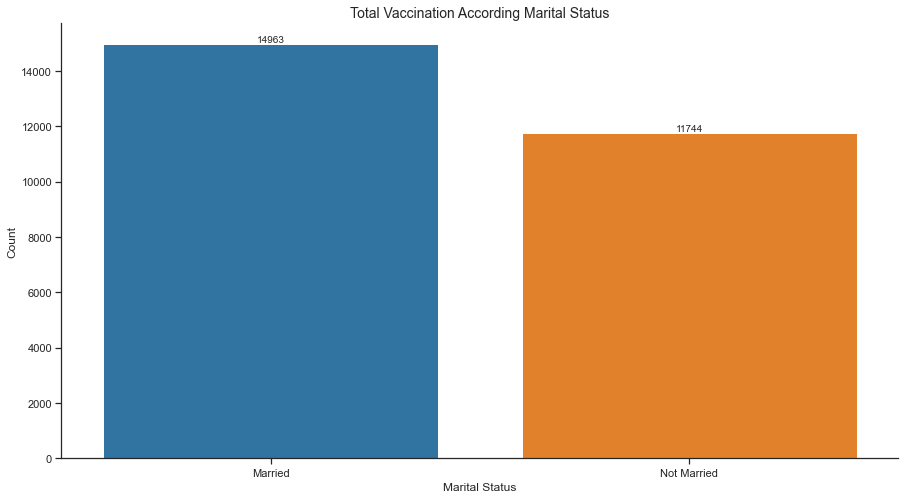

In [32]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='marital_status', order=df_features['marital_status'].value_counts().index)
ax.set_title("Total Vaccination According Marital Status", fontsize=14)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

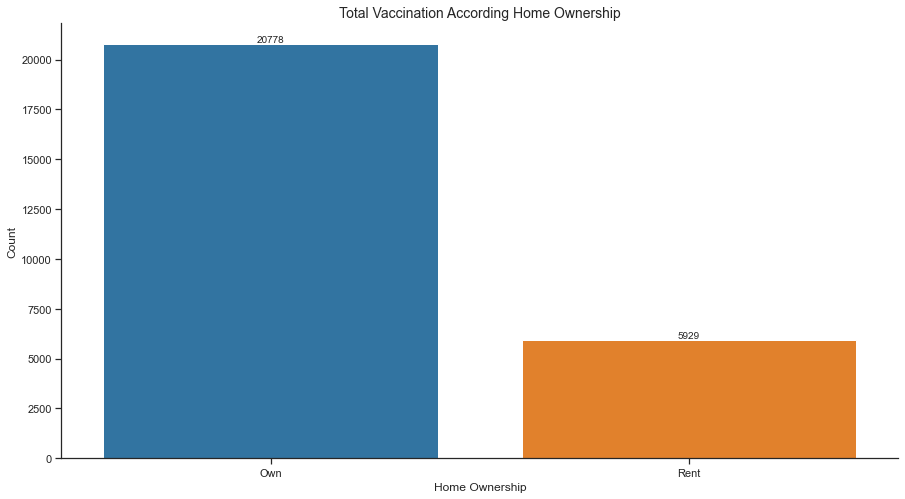

In [33]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='rent_or_own', order=df_features['rent_or_own'].value_counts().index)
ax.set_title("Total Vaccination According Home Ownership", fontsize=14)
ax.set_xlabel('Home Ownership')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

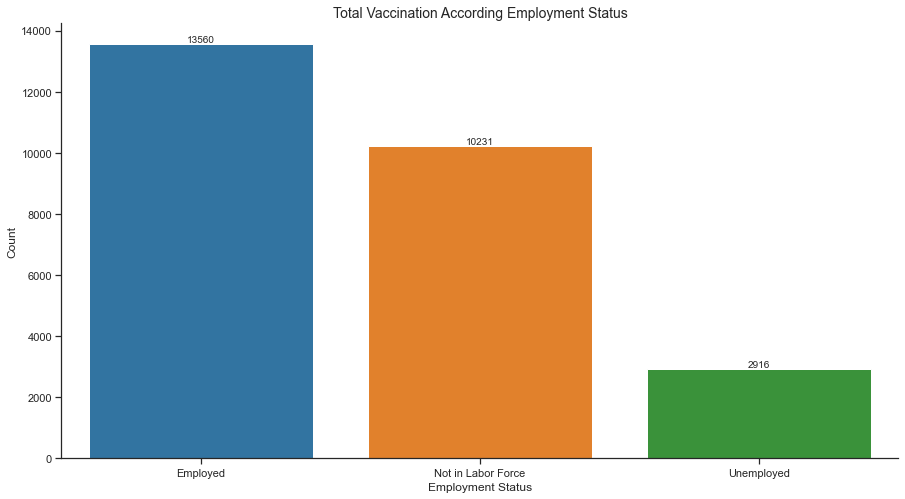

In [34]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_status', order=df_features['employment_status'].value_counts().index)
ax.set_title("Total Vaccination According Employment Status", fontsize=14)
ax.set_xlabel('Employment Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

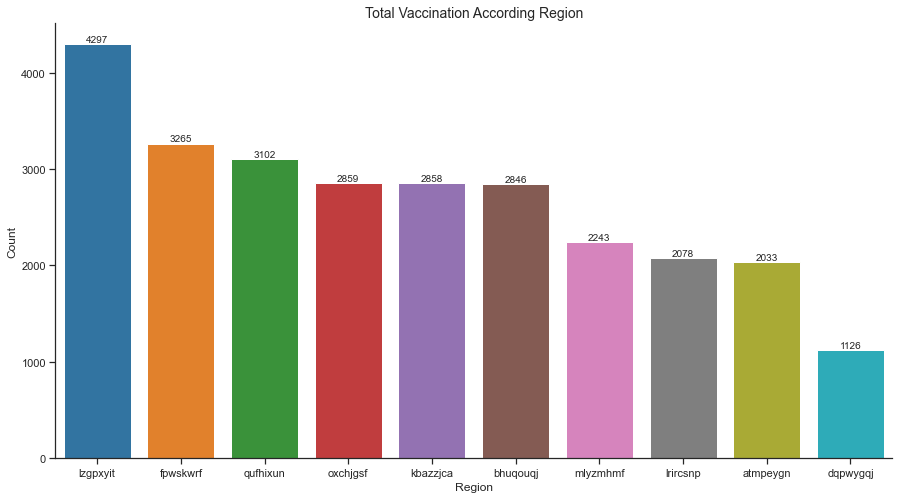

In [35]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='hhs_geo_region', order=df_features['hhs_geo_region'].value_counts().index)
ax.set_title("Total Vaccination According Region", fontsize=14)
ax.set_xlabel('Region')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

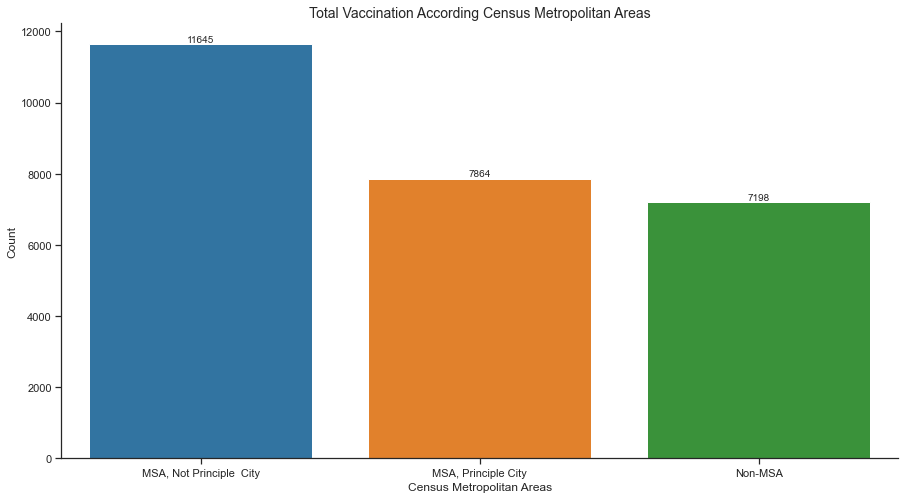

In [36]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='census_msa', order=df_features['census_msa'].value_counts().index)
ax.set_title("Total Vaccination According Census Metropolitan Areas", fontsize=14)
ax.set_xlabel('Census Metropolitan Areas')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

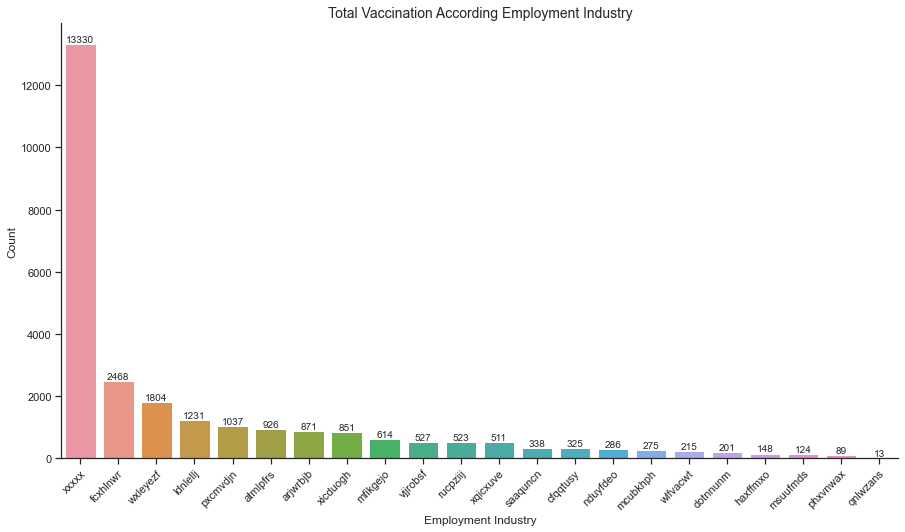

In [37]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_industry', order=df_features['employment_industry'].value_counts().index)
ax.set_title("Total Vaccination According Employment Industry", fontsize=14)
ax.set_xlabel('Employment Industry')
ax.set_xticklabels(df_features['employment_industry'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

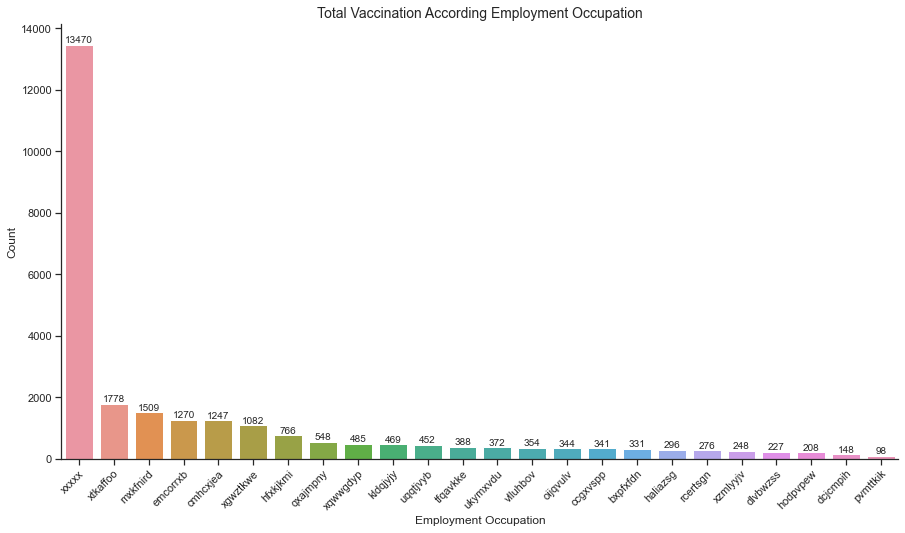

In [38]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_occupation', order=df_features['employment_occupation'].value_counts().index)
ax.set_title("Total Vaccination According Employment Occupation", fontsize=14)
ax.set_xlabel('Employment Occupation')
ax.set_xticklabels(df_features['employment_occupation'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [39]:
df_features.select_dtypes(include=['object'])

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,xxxxx,xxxxx
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",xxxxx,xxxxx
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,xxxxx,xxxxx
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,lzgpxyit,"MSA, Not Principle City",xxxxx,xxxxx
26705,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


## Modelling

### Catboost (belum diulang feature selection setelah update data cleaning)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [74]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [75]:
sfs1 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [76]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  3.0min finished

[2023-05-02 22:05:17] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  3.2min finished

[2023-05-02 22:08:30] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  3.2min finished

[2023-05-02 22:11:40] Features: 3/35 -- score: 0.8291998687211235[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [90]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7061011369206145, 0.7118158376630549, 0.718...",0.705704,"(28,)",0.014972,0.011649,0.005824
2,"(21, 28)","[0.7817477455244676, 0.7842366891563913, 0.791...",0.785562,"(21, 28)",0.01093,0.008504,0.004252
3,"(21, 26, 28)","[0.8217985333484147, 0.8251520218065574, 0.832...",0.8292,"(21, 26, 28)",0.011063,0.008608,0.004304
4,"(21, 26, 27, 28)","[0.8435825852690462, 0.8473829905084287, 0.853...",0.849077,"(21, 26, 27, 28)",0.008616,0.006704,0.003352
5,"(10, 21, 26, 27, 28)","[0.853092556031986, 0.8552019580699758, 0.8590...",0.856325,"(10, 21, 26, 27, 28)",0.00912,0.007096,0.003548
6,"(10, 21, 25, 26, 27, 28)","[0.853809772307397, 0.857762336602776, 0.86417...",0.858863,"(10, 21, 25, 26, 27, 28)",0.008396,0.006533,0.003266
7,"(10, 21, 22, 25, 26, 27, 28)","[0.8548564624871038, 0.8609549443578358, 0.864...",0.8609,"(10, 21, 22, 25, 26, 27, 28)",0.008426,0.006556,0.003278
8,"(10, 21, 22, 25, 26, 27, 28, 30)","[0.8564329244257987, 0.8619371041076493, 0.866...",0.861915,"(10, 21, 22, 25, 26, 27, 28, 30)",0.007571,0.00589,0.002945
9,"(1, 10, 21, 22, 25, 26, 27, 28, 30)","[0.8588095066717395, 0.8627212909290303, 0.868...",0.862985,"(1, 10, 21, 22, 25, 26, 27, 28, 30)",0.006364,0.004951,0.002476
10,"(1, 10, 21, 22, 25, 26, 27, 28, 30, 31)","[0.8585747190260253, 0.8620608104348213, 0.869...",0.86344,"(1, 10, 21, 22, 25, 26, 27, 28, 30, 31)",0.007346,0.005716,0.002858


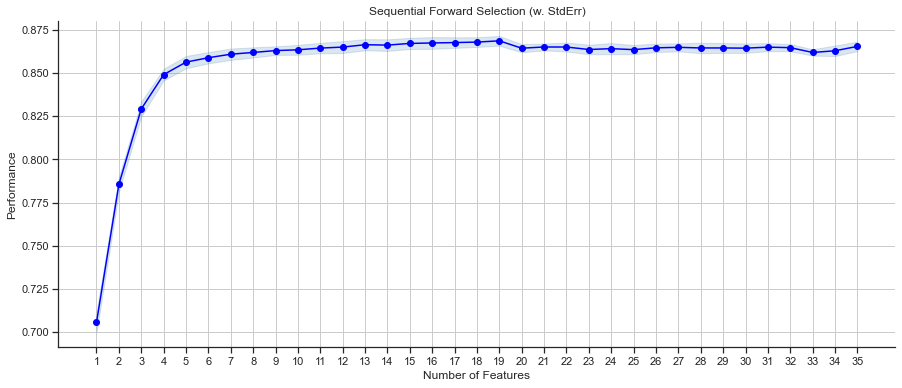

In [91]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [92]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [93]:
selected_columns_1

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

##### Seasonal Flu Vaccines

In [82]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [83]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished

[2023-05-02 23:11:36] Features: 1/35 -- score: 0.7183836938438439[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  2.6min finished

[2023-05-02 23:14:12] Features: 2/35 -- score: 0.7779178245402318[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  2.4min finished

[2023-05-02 23:16:35] Features: 3/35 -- score: 0.8114257239983178[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [94]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7266282156510848, 0.7165140310424655, 0.724...",0.718384,"(31,)",0.011555,0.00899,0.004495
2,"(0, 31)","[0.7885046409441441, 0.7809378529057273, 0.788...",0.777918,"(0, 31)",0.014959,0.011638,0.005819
3,"(0, 22, 31)","[0.8249092589799938, 0.8134191377502213, 0.812...",0.811426,"(0, 22, 31)",0.011663,0.009074,0.004537
4,"(0, 22, 30, 31)","[0.8482991742653516, 0.8318889500288369, 0.838...",0.834616,"(0, 22, 30, 31)",0.011009,0.008566,0.004283
5,"(0, 10, 22, 30, 31)","[0.858806051933909, 0.8407863473473002, 0.8481...",0.844697,"(0, 10, 22, 30, 31)",0.010782,0.008389,0.004195
6,"(0, 10, 22, 30, 31, 32)","[0.8622886306941213, 0.8474972400685636, 0.852...",0.849493,"(0, 10, 22, 30, 31, 32)",0.010007,0.007785,0.003893
7,"(0, 10, 22, 26, 30, 31, 32)","[0.8636639917299906, 0.8503951680766588, 0.856...",0.852153,"(0, 10, 22, 26, 30, 31, 32)",0.01075,0.008364,0.004182
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.865592202431042, 0.8520423492628479, 0.8594...",0.853806,"(0, 10, 13, 22, 26, 30, 31, 32)",0.010983,0.008545,0.004272
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.866819925841592, 0.8515428851327471, 0.8612...",0.855309,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.010742,0.008358,0.004179
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8672024022627409, 0.8530847342119835, 0.861...",0.856469,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.009631,0.007493,0.003747


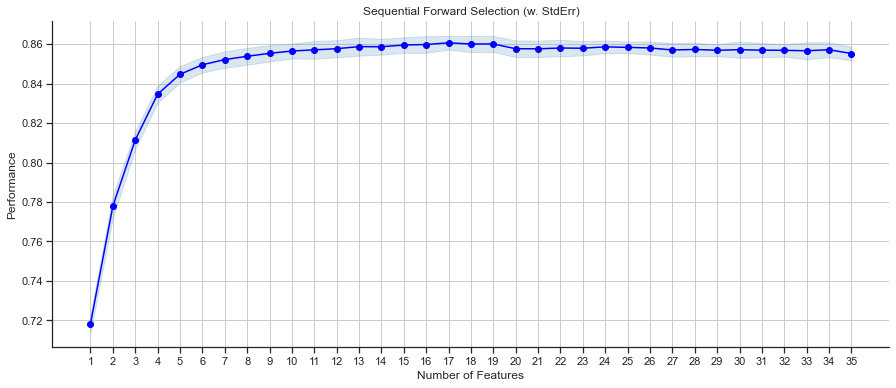

In [95]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [96]:
sfdf2['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()
selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [97]:
selected_columns_2

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_wash_hands',
 'behavioral_outside_home',
 'doctor_recc_seasonal',
 'health_worker',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

#### Model Optimization

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [99]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != float)[0]

train_dataset = Pool(data = X_train[selected_columns_1],
                     label = y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [100]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [117]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7721669453698692
  Params: 
    iterations=200,
    learning_rate=0.1933773551934663,
    random_strength=1,
    bagging_temperature=4,
    max_bin=30,
    grow_policy=Depthwise,
    min_data_in_leaf=1,
    max_depth=2,
    l2_leaf_reg=6.172494631961106e-08,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


##### Seasonal Flu Vaccines

In [103]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != float)[0]

train_dataset_se = Pool(data = X_train[selected_columns_2],
                     label = y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [104]:
def objective2(trial):
    param = {
        'iterations' : trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate' : trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength' : trial.suggest_int("random_strength", 1,10),
        'bagging_temperature' : trial.suggest_int("bagging_temperature", 0,10),
        'max_bin' : trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function" : "Logloss",
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [ ]:
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

In [118]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7921368195574383
  Params: 
    iterations=1000,
    learning_rate=0.0495571281798243,
    random_strength=3,
    bagging_temperature=8,
    max_bin=8,
    grow_policy=Depthwise,
    min_data_in_leaf=3,
    max_depth=5,
    l2_leaf_reg=58.386263935379176,
    one_hot_max_size=1024,
    auto_class_weights=Balanced,


#### Final Model

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [120]:
categorical_features_indices_h1n1 = np.where(X_train[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train[selected_columns_2].dtypes == object)[0]

model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

In [121]:
model_h1n1.fit(X_train[selected_columns_1], y_train.h1n1_vaccine)
model_flu.fit(X_train[selected_columns_2], y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(X_test[selected_columns_1])
pred_flu = model_flu.predict_proba(X_test[selected_columns_2])

In [122]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [123]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.7741938070892513

#### For Submission

In [112]:
categorical_features_indices_h1n1 = np.where(df_features[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(df_features[selected_columns_2].dtypes == object)[0]

f_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
f_model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

f_model_h1n1.fit(df_features[selected_columns_1], df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(df_test_features[selected_columns_1])
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(df_features[selected_columns_2], df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(df_test_features[selected_columns_2])
predictions_flu = predictions_flu[:,1].reshape(-1,1)

### XGBoost

In [404]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [405]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

##### h1n1 Vaccines

In [406]:
sfs1 = SFS(XGBClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [407]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   30.3s finished

[2023-05-02 19:13:50] Features: 1/35 -- score: 0.7057039455284032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   54.5s finished

[2023-05-02 19:14:45] Features: 2/35 -- score: 0.7855619144955167[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.4min finished

[2023-05-02 19:16:06] Features: 3/35 -- score: 0.8290300040587824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [410]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7061011369206145, 0.7118158376630549, 0.718...",0.705704,"(28,)",0.014972,0.011649,0.005824
2,"(21, 28)","[0.7817477455244676, 0.7842366891563913, 0.791...",0.785562,"(21, 28)",0.01093,0.008504,0.004252
3,"(21, 26, 28)","[0.8218430915877473, 0.8251777047810569, 0.832...",0.82903,"(21, 26, 28)",0.010987,0.008548,0.004274
4,"(21, 26, 27, 28)","[0.8408482517746176, 0.8444863790344743, 0.852...",0.846899,"(21, 26, 27, 28)",0.008571,0.006669,0.003334
5,"(21, 25, 26, 27, 28)","[0.845980375523131, 0.8502183908931598, 0.8579...",0.852063,"(21, 25, 26, 27, 28)",0.008644,0.006725,0.003363
6,"(21, 24, 25, 26, 27, 28)","[0.8473128382570189, 0.8494416949393411, 0.859...",0.852836,"(21, 24, 25, 26, 27, 28)",0.008785,0.006835,0.003417
7,"(21, 22, 24, 25, 26, 27, 28)","[0.8468432629655909, 0.8514655133298918, 0.858...",0.85333,"(21, 22, 24, 25, 26, 27, 28)",0.008699,0.006768,0.003384
8,"(14, 21, 22, 24, 25, 26, 27, 28)","[0.8465210726196475, 0.8543482131926591, 0.856...",0.85331,"(14, 21, 22, 24, 25, 26, 27, 28)",0.009477,0.007374,0.003687
9,"(14, 20, 21, 22, 24, 25, 26, 27, 28)","[0.8457479443227662, 0.8547000699433006, 0.854...",0.853083,"(14, 20, 21, 22, 24, 25, 26, 27, 28)",0.008297,0.006456,0.003228
10,"(14, 19, 20, 21, 22, 24, 25, 26, 27, 28)","[0.8452438792403163, 0.857472118990933, 0.8546...",0.853516,"(14, 19, 20, 21, 22, 24, 25, 26, 27, 28)",0.009938,0.007732,0.003866


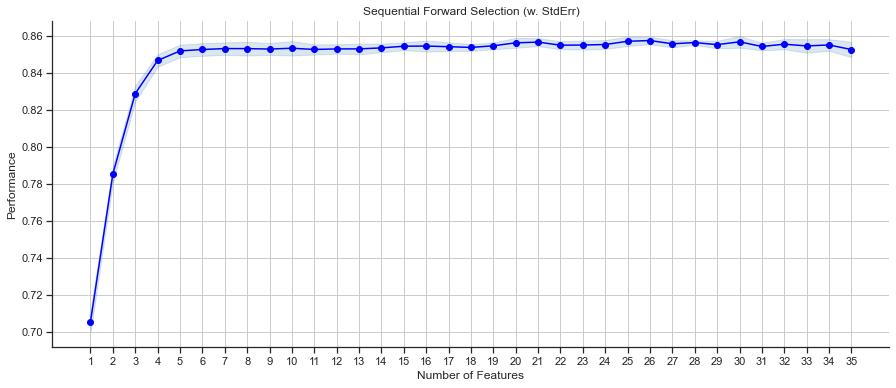

In [411]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [487]:
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [11]:
selected_columns_1 = ['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'chronic_med_condition',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa',
 'household_adults',
 'employment_industry']

##### Seasonal Flu Vaccines

In [408]:
sfs2 = SFS(XGBClassifier(n_estimators=100), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [409]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   28.4s finished

[2023-05-02 20:12:23] Features: 1/35 -- score: 0.7183836938438439[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   51.5s finished

[2023-05-02 20:13:15] Features: 2/35 -- score: 0.7778923836706837[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min finished

[2023-05-02 20:14:50] Features: 3/35 -- score: 0.8112666448194605[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [450]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.7266282156510848, 0.7165140310424655, 0.724...",0.718384,"(31,)",0.011555,0.00899,0.004495
2,"(0, 31)","[0.7885046409441441, 0.7809179952134329, 0.788...",0.777892,"(0, 31)",0.014924,0.011612,0.005806
3,"(0, 22, 31)","[0.8250652425919296, 0.8133020061449484, 0.812...",0.811267,"(0, 22, 31)",0.011915,0.00927,0.004635
4,"(0, 22, 30, 31)","[0.8463885189154591, 0.8283160043790528, 0.835...",0.831558,"(0, 22, 30, 31)",0.011649,0.009063,0.004532
5,"(0, 22, 25, 30, 31)","[0.8476592673259805, 0.833663191666446, 0.8421...",0.835758,"(0, 22, 25, 30, 31)",0.010865,0.008454,0.004227
6,"(0, 22, 25, 26, 30, 31)","[0.8506990771065558, 0.8370095006106961, 0.845...",0.83813,"(0, 22, 25, 26, 30, 31)",0.012394,0.009643,0.004822
7,"(0, 22, 25, 26, 30, 31, 32)","[0.8487937459205392, 0.8406939659092348, 0.849...",0.84027,"(0, 22, 25, 26, 30, 31, 32)",0.012102,0.009416,0.004708
8,"(0, 13, 22, 25, 26, 30, 31, 32)","[0.8518749978415552, 0.8405610057086549, 0.852...",0.841761,"(0, 13, 22, 25, 26, 30, 31, 32)",0.01287,0.010013,0.005006
9,"(0, 10, 13, 22, 25, 26, 30, 31, 32)","[0.8553423235917443, 0.8417733322128607, 0.851...",0.844526,"(0, 10, 13, 22, 25, 26, 30, 31, 32)",0.011138,0.008666,0.004333
10,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)","[0.8557252317018561, 0.8431679753557405, 0.850...",0.846023,"(0, 10, 13, 22, 23, 25, 26, 30, 31, 32)",0.009394,0.007309,0.003654


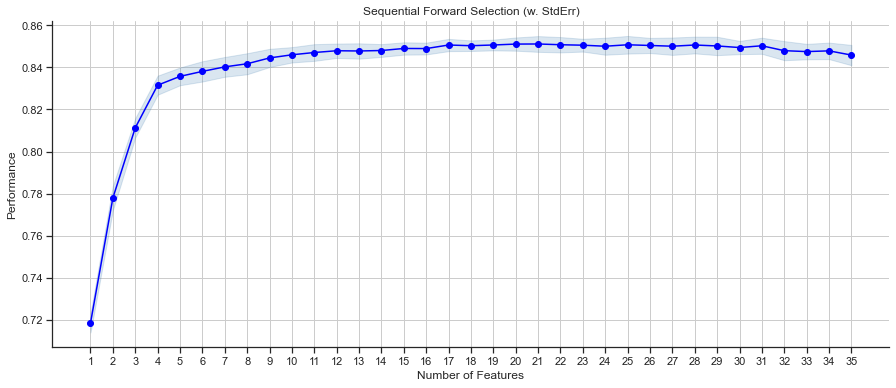

In [451]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [488]:
sfdf2['avg_score'] = sfdf2['avg_score'].astype('float')
index = sfdf2['avg_score'].idxmax()

selected_columns_2 = [all_cols[i] for i in 
                     list(sfdf2.loc[index, 'feature_idx'])]

In [12]:
selected_columns_2 = ['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

#### Model Optimization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

##### h1n1 Vaccines

In [60]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_1].select_dtypes('object').columns
col = []
ct1 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [47]:
def objective(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train[selected_columns_1]), label=y_train.h1n1_vaccine)
    dtest = xgb.DMatrix(ct.fit_transform(X_test[selected_columns_1]), label=y_test.h1n1_vaccine)
    print('test')

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.h1n1_vaccine, pred_labels)    

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [54]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6975230836888867
  Params: 
    booster=dart,
    lambda=6.227375966727043e-06,
    alpha=0.0013009943951840916,
    max_depth=4,
    eta=0.48963301939403747,
    gamma=0.00677056244687695,
    grow_policy=depthwise,
    sample_type=weighted,
    normalize_type=forest,
    rate_drop=8.829340538393375e-07,
    skip_drop=8.518372994885679e-06,


##### Seasonal Flu Vaccines

In [61]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != np.float)[0]
categorical_cols = X_train[selected_columns_2].select_dtypes('object').columns
col = []
ct2 = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

In [51]:
def objective2(trial):
    dtrain = xgb.DMatrix(ct.fit_transform(X_train[selected_columns_2]), label=y_train.seasonal_vaccine, enable_categorical=True)
    dtest = xgb.DMatrix(ct.fit_transform(X_test[selected_columns_2]), label=y_test.seasonal_vaccine, enable_categorical=True)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)

    return roc_auc_score(y_test.seasonal_vaccine, pred_labels)    

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study2 = optuna.create_study(direction="maximize", sampler=sampler)

study2.optimize(objective2, n_trials=100)

In [55]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.6975230836888867
  Params: 
    booster=gblinear,
    lambda=5.5733661662182675e-05,
    alpha=5.073550463632246e-06,


#### Final Model

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [57]:
model_h1n1 = xgb.XGBClassifier(**trial.params)
model_flu = xgb.XGBClassifier(**trial2.params)

In [62]:
model_h1n1.fit(ct1.fit_transform(X_train[selected_columns_1]), y_train.h1n1_vaccine)
model_flu.fit(ct2.fit_transform(X_train[selected_columns_2]), y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(ct1.fit_transform(X_test[selected_columns_1]))
pred_flu = model_flu.predict_proba(ct2.fit_transform(X_test[selected_columns_2]))

In [63]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [64]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.77046914366326

#### For Submission

In [66]:
f_model_h1n1 = xgb.XGBClassifier(**trial.params)
f_model_flu = xgb.XGBClassifier(**trial2.params)

f_model_h1n1.fit(ct1.fit_transform(df_features[selected_columns_1]), df_labels.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(ct1.fit_transform(df_test_features[selected_columns_1]))
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(ct2.fit_transform(df_features[selected_columns_2]), df_labels.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(ct2.fit_transform(df_test_features[selected_columns_2]))
predictions_flu = predictions_flu[:,1].reshape(-1,1)

## Submission

In [113]:
submission_df = pd.read_csv("data/submission_format.csv", 
                            index_col="respondent_id")

submission_df["h1n1_vaccine"] = predictions_h1n1
submission_df["seasonal_vaccine"] = predictions_flu

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.446143,0.297817
26708,0.138799,0.140522
26709,0.190450,0.510536
26710,0.551995,0.846578
26711,0.502789,0.274086


In [114]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.446143,0.297817
26708,0.138799,0.140522
26709,0.190450,0.510536
26710,0.551995,0.846578
26711,0.502789,0.274086
...,...,...
53410,0.273795,0.658032
53411,0.544871,0.223316
53412,0.230748,0.107870


In [115]:
name = "Catboost_optuna_with_new_cleaning_method"
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'predictions/{date}submssion_{name}.csv', index=True)